In [1]:

import pennylane as qml
from pennylane import numpy as np
import jax
from functools import partial

In [14]:
dataset = qml.data.load('qchem', molname="H2")[0]
H, qubits = dataset.hamiltonian, len(dataset.hamiltonian.wires)
print("Number of qubits = ", qubits)
print("The Hamiltonian is ", H)

Number of qubits =  4
The Hamiltonian is    (-0.22250914236600539) [Z2]
+ (-0.22250914236600539) [Z3]
+ (-0.09963387941370971) [I0]
+ (0.17110545123720225) [Z1]
+ (0.17110545123720233) [Z0]
+ (0.12051027989546245) [Z0 Z2]
+ (0.12051027989546245) [Z1 Z3]
+ (0.16584090244119712) [Z0 Z3]
+ (0.16584090244119712) [Z1 Z2]
+ (0.16859349595532533) [Z0 Z1]
+ (0.1743207725924201) [Z2 Z3]
+ (-0.04533062254573469) [Y0 Y1 X2 X3]
+ (-0.04533062254573469) [X0 X1 Y2 Y3]
+ (0.04533062254573469) [Y0 X1 X2 Y3]
+ (0.04533062254573469) [X0 Y1 Y2 X3]


In [22]:
dev = qml.device("default.qubit", wires=4, shots=100)
electrons = 2
hf = qml.qchem.hf_state(electrons, qubits)
print(hf)

[1 1 0 0]


In [31]:
@partial(qml.cut_circuit, auto_cutter=True)
@qml.qnode(dev)
def circuit(param, wires):
    for i in range(len(wires)):
        qml.RX(param[i*3], wires=i)
        qml.RY(param[i*3+1], wires=i)
        qml.RZ(param[i*3+2], wires=i)
    qml.DoubleExcitation(param, wires=[0, 1, 2, 3])
    return qml.expval(H)

param = np.random.random(3*4)
print(param)
#print(circuit(param, wires=range(3)))
#qml.draw_mpl(circuit)(param, wires=range(3))
res = circuit(param, wires=range(4))

[0.74268213 0.30663481 0.49786381 0.32351185 0.16016304 0.42280037
 0.29099792 0.68162761 0.76517697 0.43513817 0.87023648 0.95140947]


/usr/local/python/3.11.8/lib/python3.11/site-packages/pennylane/qcut/cutstrategy.py:367: UserWarning: The numer of partition attempts seems high (40).
  warnings.warn(f"The numer of partition attempts seems high ({len(ks)}).")


TypeError: kahypar_cut() got an unexpected keyword argument 'shots'

In [ ]:
def cost_fn(param):
    return circuit(param, wires=range(qubits))

In [ ]:
import optax

max_iterations = 100
conv_tol = 1e-06

opt = optax.sgd(learning_rate=0.4)

In [ ]:
theta = np.array(0.)

# store the values of the cost function
energy = [cost_fn(theta)]

# store the values of the circuit parameter
angle = [theta]

opt_state = opt.init(theta)

for n in range(max_iterations):

    gradient = jax.grad(cost_fn)(theta)
    updates, opt_state = opt.update(gradient, opt_state)
    theta = optax.apply_updates(theta, updates)

    angle.append(theta)
    energy.append(cost_fn(theta))

    conv = np.abs(energy[-1] - energy[-2])

    print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

    if conv <= conv_tol:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")

/usr/local/python/3.11.8/lib/python3.11/site-packages/pennylane/qcut/cutstrategy.py:367: UserWarning: The numer of partition attempts seems high (57).
  warnings.warn(f"The numer of partition attempts seems high ({len(ks)}).")


ValueError: Unable to find a circuit cutting that satisfies all constraints. Are the constraints too strict?

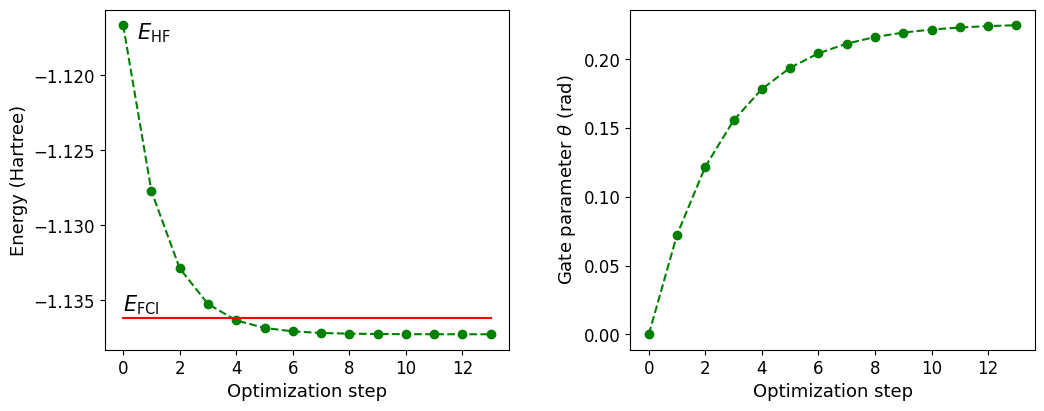

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Full configuration interaction (FCI) energy computed classically
E_fci = -1.136189454088

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 2), energy, "go", ls="dashed")
ax1.plot(range(n + 2), np.full(n + 2, E_fci), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
ax1.text(0.5, -1.1176, r"$E_\mathrm{HF}$", fontsize=15)
ax1.text(0, -1.1357, r"$E_\mathrm{FCI}$", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add angle plot on column 2
ax2 = fig.add_subplot(122)
ax2.plot(range(n + 2), angle, "go", ls="dashed")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Gate parameter $\\theta$ (rad)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.show()